## K-nearest neighbors classifier

In [1]:
import numpy as np
import os

# Load the data
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    cifar = dict(npz_file.items())

print(cifar.keys())

pixels = cifar['pixels']
overfeat = cifar['overfeat']
labels = cifar['labels']
names = cifar['names']

print('pixels shape :',pixels.shape, ', dtype:', pixels.dtype)
print('overfeat shape :',overfeat.shape, ', dtype:', overfeat.dtype)
print('labels shape :',labels.shape, ', dtype:', labels.dtype)
print('Categories:', names)

dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])
pixels shape : (5000, 3072) , dtype: uint8
overfeat shape : (5000, 4096) , dtype: float32
labels shape : (5000,) , dtype: int64
Categories: ['truck' 'car' 'airplane' 'ship']


In [2]:
# split the Overfeat data into train/test sets w/ same proportion of classes in each subset

import pandas as pd
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    overfeat, labels, train_size=4000, test_size=1000, 
    stratify=labels , # same class distribution
    random_state=0)

print('Train:', X_tr.shape, y_tr.shape)
print('Test:', X_te.shape, y_te.shape)
print('class distribution in train set:','\n', pd.value_counts(y_tr, normalize=True))
print('class distribution in test set:','\n', pd.value_counts(y_te, normalize=True))

Train: (4000, 4096) (4000,)
Test: (1000, 4096) (1000,)
class distribution in train set: 
 3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64
class distribution in test set: 
 3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64


In [3]:
# Then, split the train set (4,000 points) into a (smaller) train and validation sets
# with respectively 3,200 and 800 samples

X_tr2, X_val, y_tr2, y_val = train_test_split(
    X_tr, y_tr, train_size=3200, test_size=800, 
    stratify=y_tr , # same class distribution
    random_state=0)

print('Train2:', X_tr2.shape, y_tr2.shape)
print('Val:', X_val.shape, y_val.shape)
print('Class distribution in train set:','\n',pd.value_counts(y_tr2, normalize=True))
print('Class distribution in test set:','\n', pd.value_counts(y_val, normalize=True))

Train2: (3200, 4096) (3200,)
Val: (800, 4096) (800,)
Class distribution in train set: 
 3    0.25
1    0.25
2    0.25
0    0.25
dtype: float64
Class distribution in test set: 
 3    0.25
2    0.25
1    0.25
0    0.25
dtype: float64


#### Create a k-NN classifier with PCA. Tune k and the distance metric

After a few tries of grid search that led to slightly inconsistent results, I adopted a different approach : first I tune the k metric, then the other parameters. However, I still find the results a bit inconsistent (e.g. k value varies a lot when accuracy varies very little) , maybve due to a noisy dataset.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create k-NN classifier
pipe = Pipeline([
    #('scaler', StandardScaler()), # With standardization
    ('pca', PCA(n_components=172)), # PCA preprocessing, number of components to retain 90% of the variance explained.
    ('knn', KNeighborsClassifier(
        algorithm='brute', # Brute-force search
        n_jobs=-1 # As many parallel jobs as possible
    ))
])

In [5]:
# grid search for k
from sklearn.model_selection import ParameterGrid

# grid of parameters 
grid = ParameterGrid({'knn__n_neighbors': list(range(1,100,2))})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 50


In [6]:
%%time
# Save accuracy on test set
test_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier on smaller train set
    pipe.fit(X_tr2, y_tr2)
    
    # Save accuracy on train set
    params_dict['accuracy_tr'] = pipe.score(X_tr2, y_tr2)

    # Save accuracy on validation set
    params_dict['accuracy_val'] = pipe.score(X_val, y_val)
    
    # Save result
    test_scores.append(params_dict)
    
print('done')

Combination 1/50
Combination 2/50
Combination 3/50
Combination 4/50
Combination 5/50
Combination 6/50
Combination 7/50
Combination 8/50
Combination 9/50
Combination 10/50
Combination 11/50
Combination 12/50
Combination 13/50
Combination 14/50
Combination 15/50
Combination 16/50
Combination 17/50
Combination 18/50
Combination 19/50
Combination 20/50
Combination 21/50
Combination 22/50
Combination 23/50
Combination 24/50
Combination 25/50
Combination 26/50
Combination 27/50
Combination 28/50
Combination 29/50
Combination 30/50
Combination 31/50
Combination 32/50
Combination 33/50
Combination 34/50
Combination 35/50
Combination 36/50
Combination 37/50
Combination 38/50
Combination 39/50
Combination 40/50
Combination 41/50
Combination 42/50
Combination 43/50
Combination 44/50
Combination 45/50
Combination 46/50
Combination 47/50
Combination 48/50
Combination 49/50
Combination 50/50
done
CPU times: user 3min 32s, sys: 25.3 s, total: 3min 58s
Wall time: 2min 24s


In [7]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

# Print scores
scores_df.sort_values(by='accuracy_val', ascending=False).head(10)

,accuracy_tr,accuracy_val,knn__n_neighbors
14,0.797813,0.77875,29
37,0.785312,0.77875,75
40,0.785312,0.77750,81
39,0.785625,0.77750,79
18,0.795937,0.77750,37
38,0.785312,0.77625,77
5,0.818125,0.77625,11
34,0.787188,0.77625,69
36,0.785312,0.77500,73
16,0.793125,0.77375,33


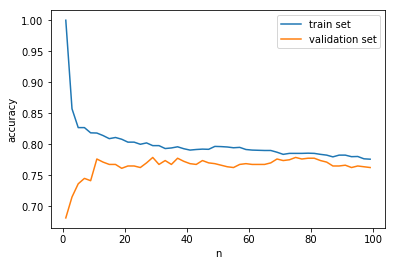

In [8]:
# Plot train & validation curve
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(scores_df.knn__n_neighbors, scores_df.accuracy_tr, label = 'train set')
plt.plot(scores_df.knn__n_neighbors, scores_df.accuracy_val, label = 'validation set')
plt.xlabel('n')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [9]:
# Create k-NN classifier
pipe = Pipeline([
    ('scaler', StandardScaler()), # With standardization
    ('pca', PCA()), # PCA preprocessing, number of components to retain 90% of the variance explained.
    ('knn', KNeighborsClassifier(
        algorithm='brute', # Brute-force search
        n_jobs=-1 # As many parallel jobs as possible
    ))])

# grid search with best k value fixed
grid = ParameterGrid({
    'scaler': [None, StandardScaler()],
    'pca' : [None, PCA(n_components=172)],
    'knn__n_neighbors': [73], # set after a first grid search with only one parameter (k)
    'knn__p': [1, 2], # L1 and L2 distance metrics
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 8


In [10]:
# Save accuracy on test set
test_scores = []

# Enumerate combinations starting from 1
for i, params_dict in enumerate(grid, 1):
    # Print progress
    print('Combination {}/{}'.format(
        i, len(grid) # Total number of combinations
    ))
    
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier on smaller train set
    pipe.fit(X_tr2, y_tr2)
    
    # Save accuracy on train set
    params_dict['accuracy_tr'] = pipe.score(X_tr2, y_tr2)

    # Save accuracy on validation set
    params_dict['accuracy_val'] = pipe.score(X_val, y_val)
    
    # Save result
    test_scores.append(params_dict)
    
print('done')

Combination 1/8
Combination 2/8
Combination 3/8
Combination 4/8
Combination 5/8
Combination 6/8
Combination 7/8
Combination 8/8
done


In [11]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

# Print scores
scores_df.sort_values(by='accuracy_val', ascending=False).head(10)

,accuracy_tr,accuracy_val,knn__n_neighbors,knn__p,pca,scaler
6,0.786250,0.77500,73,2,"PCA(copy=True, iterated_power='auto', n_compon...",None
1,0.784062,0.76750,73,1,None,"StandardScaler(copy=True, with_mean=True, with..."
7,0.788125,0.76750,73,2,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."
0,0.785625,0.76625,73,1,None,None
4,0.786563,0.76250,73,2,None,None
5,0.786563,0.76000,73,2,None,"StandardScaler(copy=True, with_mean=True, with..."
2,0.781875,0.75750,73,1,"PCA(copy=True, iterated_power='auto', n_compon...",None
3,0.779687,0.75625,73,1,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with..."


In [12]:
best = scores_df.sort_values(by='accuracy_val', ascending=False)[0:1]
print('Top accuracy on validation set:', best.iloc[0,1], ' with k:', best.iloc[0,2],
    'and distance metric:', best.iloc[0,3]
      #, 'and PCA', best['pca'], 'and standardized', best['scaler']
     )

Top accuracy on validation set: 0.775  with k: 73 and distance metric: 2


In [13]:
# Create k-NN classifier with tuned parameters
knn_best = KNeighborsClassifier(p= best.iloc[0,3], 
                                n_neighbors= best.iloc[0,2], 
                                algorithm='brute', 
                                n_jobs=-1)

pipe = Pipeline([('scaler', None),
                 ('pca', PCA(n_components=172)),
                 ('knn', knn_best)])

# Fit it to the entire train data
pipe.fit(X_tr, y_tr)

# evaluate its accuracy on the test set
accuracy_best_knn = pipe.score(X_te, y_te)
print ('K-NN accuracy on the test set: {:.3f}'.format(accuracy_best_knn))

K-NN accuracy on the test set: 0.765


In [19]:
# save results
import csv
results = ['KNeighbors', accuracy_best_knn]
with open(r'results.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(results)

### Choose an image from the test set and plot its 10 nearest neighbors.

In [15]:
# Pick a random image from the test set
import random
rdm_num = random.randint(1,len(X_te))
img = X_te[rdm_num].reshape(1, -1)

#extract the PCA transformer and the KNeighborsClassifier estimator from your pipeline
#Apply PCA to your test image 
img_pca = pipe.named_steps['pca'].transform(img)

#pass the result to the kneighbors(X, n_neighbors) function of your k-NN estimator
neighbors = pipe.named_steps['knn'].kneighbors(img_pca, 10)

#Use the indexes to extract the pixels of the ten images from the matrix of pixels
idx = np.ravel(neighbors[1])

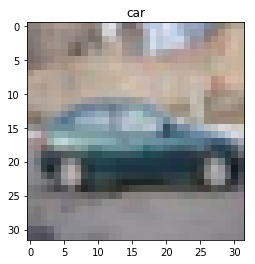

In [16]:
#and plot them with the imshow() function.
# Plotting the original image
flat_img = pixels[rdm_num]
img = flat_img.reshape(32, 32, 3)
plt.imshow(img)
plt.title(names[labels[rdm_num]])
plt.show()

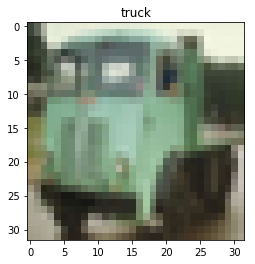

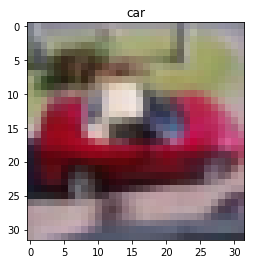

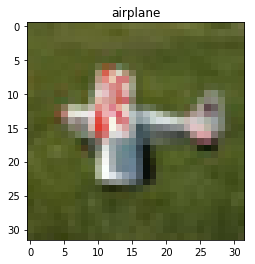

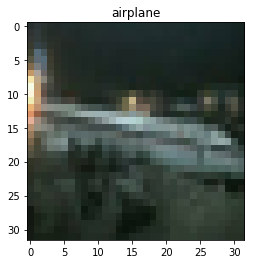

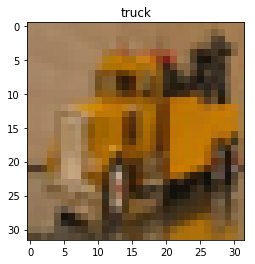

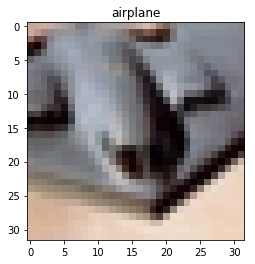

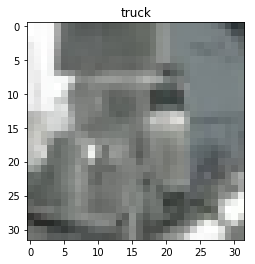

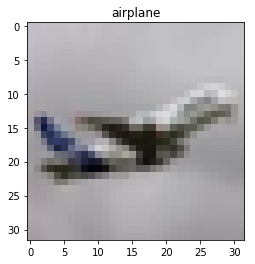

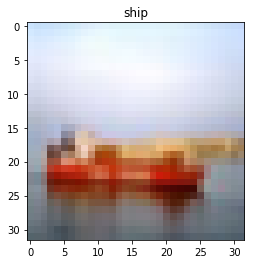

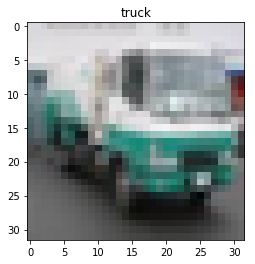

In [17]:
# Plotting its 10 neighrest neighbors from the train set
for i, x in enumerate(idx):
    flat_img = pixels[x, :]
    img = flat_img.reshape(32, 32, 3)
    plt.imshow(img)
    plt.title(names[labels[x]])
    plt.show()